# General Residual Error Prediction Object Scratch

In [1]:
from darts import TimeSeries
from typing import Optional
import pandas as pd
import matplotlib.pyplot as plt
from optuna.integration import PyTorchLightningPruningCallback
import pandas as pd
from darts.models import GaussianProcessFilter
from darts import TimeSeries
from sklearn.gaussian_process.kernels import RBF
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
import ray
import os
import optuna
from darts.models import TCNModel
import argparse
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

class ResidualForecaster():
    def __init__(self,
                 input_csv_name: Optional[str] = None,
                 target_variable_column_name: Optional[str] = None,
                 predicted_target_column_name: Optional[str] = None,
                 datetime_column_name: Optional[str] = None,
                 covariates_names: Optional[list] = None,
                 output_csv_name: Optional[str] = "residual_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 tune_model: Optional[bool] = False,
                 model_hyperparameters: Optional[dict] = None
                 ):

        self.input_csv_name = input_csv_name
        self.df = pd.read_csv(self.input_csv_name)
        self.target_variable_column_name = target_variable_column_name
        self.predicted_target_column_name = predicted_target_column_name
        self.datetime_column_name = datetime_column_name
        self.covariates_names = covariates_names
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        if model_hyperparameters == None:
            self.hyperparams = {"input_chunk_length" : 180}
        else:
            self.hyperparams = model_hyperparameters

        self._preprocess_data()
    
    def make_stitched_series(self, variable_tseries):
        """
        Returns a time series where the gaps have been filled in via
        Gaussian Process Filters
        """
        kernel = RBF()
        
        gpf_missing = GaussianProcessFilter(kernel=kernel, 
                                            alpha=0.001, 
                                            n_restarts_optimizer=100)
        
        gpf_missing_big_gaps = GaussianProcessFilter(kernel=kernel, 
                                                     alpha=2, 
                                                     n_restarts_optimizer=10)
        stitched_series = {}
    
        # Filtering the TimeSeries
        try:
            filtered = gpf_missing.filter(variable_tseries, num_samples=500)
            filtered_big_gaps = gpf_missing_big_gaps.filter(variable_tseries, 
                                                            num_samples=500)
        except:
            return None
    
        #if there is a gap over 7 indices, use big gap filter
        gap_series = variable_tseries.gaps()
        stitched_df = filtered.pd_dataframe()
        replacement_df = filtered_big_gaps.pd_dataframe()
        
        for index, row in gap_series.iterrows():
            if row["gap_size"] > 7:
                for date in pd.date_range(row["gap_start"], row["gap_end"]):
                    stitched_df.loc[date] = replacement_df.loc[date]
        
        stitched_series = TimeSeries.from_times_and_values(
                                    stitched_df.index, 
                                    stitched_df.values.reshape(
                                                len(stitched_df), 
                                                1, 
                                                -1))
        
        return stitched_series
        
    def _preprocess_data(self):
        """
        Performs gap filling and processing of data into format that
        Darts models will accept
        """
        times = pd.to_datetime(self.df[self.datetime_column_name])
        times = pd.DatetimeIndex(times)
        variable_list = self.covariates_names + [self.target_variable_column_name,
                                                self.predicted_target_column_name]
        
        var_series_dict = {var: TimeSeries.from_times_and_values(times, 
                                                                 self.df[var], 
                                                                 fill_missing_dates=True,
                                                                 freq="D") 
                                                        for var in variable_list}

        stitched_series_dict = {var: self.make_stitched_series(var_series_dict[var])
                                                    for var in variable_list}
        self.inputs = stitched_series_dict[self.target_variable_column_name] - \
                       stitched_series_dict[self.predicted_target_column_name]

        self.covariates = stitched_series_dict[self.covariates_names[0]]
        for cov_var in self.covariates_names[1:]:
            self.covariates = self.covariates.concatenate(stitched_series_dict[cov_var], 
                                                          axis=1, 
                                                          ignore_time_axis=True)

        # Should add an if statement here for tuning
        year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=year, month=month, day=day)
        self.training_set, self.validation_set = self.inputs.split_before(split_date)



    def tune(self,
             input_chunk_length: Optional[list] = [31, 60, 180, 356],
             kernel_size: Optional[list] = [2, 3, 5],
             num_filters: Optional[list] = [1, 3, 5],
             num_layers: Optional[list] = [None, 1, 2, 3],
             dilation_base: Optional[list] = [1, 2, 3],
             dropout: Optional[list] = [0.1, 0.2, 0.3]):
        """
        Sets up Optuna trial to perform hyperparameter tuning
        """
        # Relevant to tuning
        def objective(trial):
            callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
        
            # Hyperparameters
            input_chunk_length_ = trial.suggest_categorical("input_chunk_length", 
                                                               input_chunk_length)
            kernel_size_ = trial.suggest_categorical("kernel_size", kernel_size)
            num_filters_ = trial.suggest_categorical("num_filters", num_filters)
            num_layers_ = trial.suggest_categorical("num_layers", num_layers)
            dilation_base_ = trial.suggest_categorical("dilation_base", dilation_base)
            dropout_ = trial.suggest_categorical("dropout", dropout)
        
            tcn_model = TCNModel(input_chunk_length=input_chunk_length_,
                            kernel_size=kernel_size_,
                            num_filters=num_filters_,
                            dilation_base=dilation_base_,
                            output_chunk_length=30,
                            likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]))
        
            tcn_model.fit(self.training_set,
                          past_covariates=self.covariates,
                          epochs=400, 
                          verbose=False)
        
            predictions = tcn_model.predict(n=len(self.validation_set[:30]), 
                                            past_covariates=self.covariates, 
                                            num_samples=50)
            smapes = smape(self.validation_set[:30], predictions, n_jobs=-1, verbose=False)
            smape_val = np.mean(smapes)
        
            return smape_val if smape_val != np.nan else float("inf")


        study = optuna.create_study(direction="minimize")
        
        study.optimize(objective, n_trials=3) # Note 10 trials pretty meaningless here
        
        # We could also have used a command as follows to limit the number of trials instead:
        # study.optimize(objective, n_trials=100, callbacks=[print_callback])
        
        # Finally, print the best value and best hyperparameters:
        #print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")
        self.hyperparams = study.best_trial.params

    def make_residual_forecasts(self):
        """
        This function fits a TCN model to the residual error
        """
        print(self.hyperparams)
        tcn = TCNModel(**self.hyperparams,
               output_chunk_length=30,
               likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
               random_state=0)
    
        tcn.fit(self.training_set,
                past_covariates=self.covariates,
                epochs=500, 
                verbose=False)

        predictions = tcn.predict(n=30,
                                  past_covariates=self.covariates, 
                                  num_samples=500)

        predictions.pd_dataframe().to_csv(self.output_csv_name)
    

In [ ]:
self.covariates.pd_dataframe()
self.historical_forecasts.pd_dataframe()
self.historical_ground_truth.pd_dataframe()
self.residuals.pd_dataframe()

In [ ]:
from copy import deepcopy
start_date = max(block_rnn_forecaster.historical_forecasts.time_index[0],
                           block_rnn_forecaster.historical_ground_truth.time_index[0],
                           block_rnn_forecaster.covariates.time_index[0])
# I think you need to have them all start at same start date
covariates = deepcopy(block_rnn_forecaster.covariates).slice(start_date, end_date)
historical_forecasts = block_rnn_forecaster.historical_forecasts.slice(start_date, end_date)
historical_ground_truth = block_rnn_forecaster.historical_ground_truth.slice(start_date, end_date)
for time_series in [historical_forecasts, historical_ground_truth]:
    _, time_series = time_series.split_before(covariate_split_date)
    covariates = covariates.concatenate(time_series, axis=1, ignore_time_axis=True)

In [39]:
class ResidualForecasterDarts():
    def __init__(self,
                 historical_forecasts: Optional[TimeSeries] = None,
                 historical_ground_truth: Optional[TimeSeries] = None,
                 covariates: Optional[TimeSeries] = None,
                 output_csv_name: Optional[str] = "residual_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 tune_model: Optional[bool] = False,
                 model_hyperparameters: Optional[dict] = None
                 ):

        self.historical_forecasts = historical_forecasts
        self.historical_ground_truth = historical_ground_truth
        self.residuals = self.historical_ground_truth - self.historical_forecasts
        self.covariates = covariates
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        if model_hyperparameters == None:
            self.hyperparams = {"input_chunk_length" : 180}
        else:
            self.hyperparams = model_hyperparameters
        self._preprocess_data()
 
        
    def _preprocess_data(self):
        """
        Divides time series into training and validation sets
        """
        #TO DO: STACK COVARIATES, FORECAST AND OBSERVED
        start_date = max(self.historical_forecasts.time_index[0],
                         self.historical_ground_truth.time_index[0],
                         self.covariates.time_index[0])
        end_date = min(self.historical_forecasts.end_time(),
                       self.historical_ground_truth.end_time(),
                       self.covariates.end_time())
        self.covariates = self.covariates.slice(start_date, end_date)
        self.historical_forecasts = self.historical_forecasts.slice(start_date, end_date)
        self.historical_ground_truth = self.historical_ground_truth.slice(start_date, end_date)
        for time_series in [self.historical_forecasts, self.historical_ground_truth]:
            self.covariates = self.covariates.concatenate(time_series, axis=1, ignore_time_axis=True)
        
        # Should add an if statement here for tuning
        year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=year, month=month, day=day)
        self.residuals = self.residuals.slice(start_date, end_date)
        self.training_set, self.validation_set = self.residuals.split_before(split_date)



    def tune(self,
             input_chunk_length: Optional[list] = [31, 60, 180, 356],
             kernel_size: Optional[list] = [2, 3, 5],
             num_filters: Optional[list] = [1, 3, 5],
             num_layers: Optional[list] = [None, 1, 2, 3],
             dilation_base: Optional[list] = [1, 2, 3],
             dropout: Optional[list] = [0.1, 0.2, 0.3]):
        """
        Sets up Optuna trial to perform hyperparameter tuning
        """
        # Relevant to tuning
        def objective(trial):
            callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
        
            # Hyperparameters
            input_chunk_length_ = trial.suggest_categorical("input_chunk_length", 
                                                               input_chunk_length)
            kernel_size_ = trial.suggest_categorical("kernel_size", kernel_size)
            num_filters_ = trial.suggest_categorical("num_filters", num_filters)
            num_layers_ = trial.suggest_categorical("num_layers", num_layers)
            dilation_base_ = trial.suggest_categorical("dilation_base", dilation_base)
            dropout_ = trial.suggest_categorical("dropout", dropout)
        
            tcn_model = TCNModel(input_chunk_length=input_chunk_length_,
                            kernel_size=kernel_size_,
                            num_filters=num_filters_,
                            dilation_base=dilation_base_,
                            output_chunk_length=30,
                            likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]))
        
            tcn_model.fit(self.training_set,
                          past_covariates=self.covariates,
                          epochs=400, 
                          verbose=False)
        
            predictions = tcn_model.predict(n=len(self.validation_set[:30]), 
                                            past_covariates=self.covariates, 
                                            num_samples=50)
            smapes = smape(self.validation_set[:30], predictions, n_jobs=-1, verbose=False)
            smape_val = np.mean(smapes)
        
            return smape_val if smape_val != np.nan else float("inf")


        study = optuna.create_study(direction="minimize")
        
        study.optimize(objective, n_trials=3) # Note 10 trials pretty meaningless here
        
        # We could also have used a command as follows to limit the number of trials instead:
        # study.optimize(objective, n_trials=100, callbacks=[print_callback])
        
        # Finally, print the best value and best hyperparameters:
        #print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")
        self.hyperparams = study.best_trial.params

    def make_residual_forecasts(self):
        """
        This function fits a TCN model to the residual error
        """
        print(self.hyperparams)
        tcn = TCNModel(**self.hyperparams,
               output_chunk_length=30,
               likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
               random_state=0)
    
        tcn.fit(self.training_set,
                past_covariates=self.covariates,
                epochs=500, 
                verbose=False)

        self.predictions = tcn.predict(n=30,
                                  past_covariates=self.covariates, 
                                  num_samples=500)

        self.predictions.pd_dataframe().to_csv(self.output_csv_name)
    

In [55]:
model = ResidualForecaster(input_csv_name="aquatics-ARIK-oxygen-Predicted.csv",
                          target_variable_column_name="oxygen",
                          predicted_target_column_name=".pred",
                          datetime_column_name="datetime",
                          covariates_names=["air_temperature"],
                          output_csv_name="trash.csv",
                          validation_split_date="2023-04-01",
                          tune_model=True)

model.tune()
model.make_residual_forecasts()

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

Predicting: 0it [00:00, ?it/s]

[I 2023-06-27 01:10:01,180] Trial 0 finished with value: 191.66560692890516 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 0 with value: 191.66560692890516.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-27 01:11:13,094] Trial 1 finished with value: 198.3565203266736 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 0 with value: 191.66560692890516.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-27 01:12:25,273] Trial 2 finished with value: 178.4422404888918 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 5, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.2}. Best is trial 2 with value: 178.4422404888918.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 5, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [6]:
df = pd.read_csv("trash.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((34, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

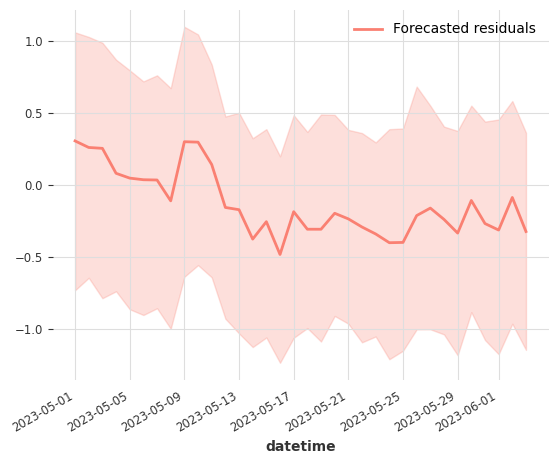

In [11]:
plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecasted residuals")
plt.show()

After making this, it makes sense to build a "Base forecasting" class.

In [100]:
df = pd.read_csv("aquatics-ARIK-oxygen-Predicted.csv")
df.head()

,datetime,.pred,oxygen,air_temperature,surface_downwelling_longwave_flux_in_air,surface_downwelling_shortwave_flux_in_air,precipitation_flux,air_pressure,relative_humidity,northward_wind,eastward_wind
0,2020-11-02,6.526266,6.119156,13.359830,272.077880,162.629032,0.0,88821.367692,0.309830,2.668139,0.257750
1,2020-11-03,6.075640,5.877618,16.389842,278.678338,158.225806,0.0,88163.690199,0.241677,2.488065,1.287034
2,2020-11-04,5.625103,5.172174,18.337971,304.047355,151.000000,0.0,88007.810631,0.242501,3.420230,-2.225313
3,2020-11-05,5.607800,5.053873,16.067992,282.212475,153.540323,0.0,88587.113575,0.278865,1.365854,-0.820159
4,2020-11-06,5.341532,5.348101,17.385899,280.930195,143.596774,0.0,87818.473118,0.250312,1.305135,6.879596


Things to do: make this so it works with different types of models, also make it so that it works with Ray

In [29]:
from darts.models import BlockRNNModel, TCNModel, RNNModel, TransformerModel

class BaseForecaster():
    def __init__(self,
                 model: Optional[str] = None,
                 input_csv_name: Optional[str] = None,
                 target_variable_column_name: Optional[str] = None,
                 datetime_column_name: Optional[str] = None,
                 covariates_names: Optional[list] = None,
                 output_csv_name: Optional[str] = "residual_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 model_hyperparameters: Optional[dict] = None,
                 ):
        self.model_ = {"BlockRNN": BlockRNNModel, 
                       "TCN": TCNModel, 
                       "RNN": RNNModel, 
                       "Transformer": TransformerModel}[model]
        self.input_csv_name = input_csv_name
        self.df = pd.read_csv(self.input_csv_name)
        self.target_variable_column_name = target_variable_column_name
        self.datetime_column_name = datetime_column_name
        self.covariates_names = covariates_names
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        if model_hyperparameters == None:
            self.hyperparams = {"input_chunk_length" : 180}
        else:
            self.hyperparams = model_hyperparameters

        self._preprocess_data()
    
    def make_stitched_series(self, variable_tseries):
        """
        Returns a time series where the gaps have been filled in via
        Gaussian Process Filters
        """
        kernel = RBF()
        
        gpf_missing = GaussianProcessFilter(kernel=kernel, 
                                            alpha=0.001, 
                                            n_restarts_optimizer=100)
        
        gpf_missing_big_gaps = GaussianProcessFilter(kernel=kernel, 
                                                     alpha=2, 
                                                     n_restarts_optimizer=10)
        stitched_series = {}
    
        # Filtering the TimeSeries
        try:
            filtered = gpf_missing.filter(variable_tseries, num_samples=500)
            filtered_big_gaps = gpf_missing_big_gaps.filter(variable_tseries, 
                                                            num_samples=500)
        except:
            return None
    
        #if there is a gap over 7 indices, use big gap filter
        gap_series = variable_tseries.gaps()
        stitched_df = filtered.pd_dataframe()
        replacement_df = filtered_big_gaps.pd_dataframe()
        
        for index, row in gap_series.iterrows():
            if row["gap_size"] > 7:
                for date in pd.date_range(row["gap_start"], row["gap_end"]):
                    stitched_df.loc[date] = replacement_df.loc[date]
        
        stitched_series = TimeSeries.from_times_and_values(
                                    stitched_df.index, 
                                    stitched_df.values.reshape(
                                                len(stitched_df), 
                                                1, 
                                                -1))
        
        return stitched_series
        
    def _preprocess_data(self):
        """
        Performs gap filling and processing of data into format that
        Darts models will accept
        """
        times = pd.to_datetime(self.df[self.datetime_column_name])
        times = pd.DatetimeIndex(times)
        variable_list = self.covariates_names + [self.target_variable_column_name]
        
        var_series_dict = {var: TimeSeries.from_times_and_values(times, 
                                                                 self.df[var], 
                                                                 fill_missing_dates=True,
                                                                 freq="D") 
                                                        for var in variable_list}

        stitched_series_dict = {var: self.make_stitched_series(var_series_dict[var])
                                                    for var in variable_list}
        self.inputs = stitched_series_dict[self.target_variable_column_name]

        # Initializing covariates list then concatenating in for loop
        self.covariates = stitched_series_dict[self.covariates_names[0]]
        for cov_var in self.covariates_names[1:]:
            self.covariates = self.covariates.concatenate(stitched_series_dict[cov_var], 
                                                          axis=1, 
                                                          ignore_time_axis=True)

        # Should add an if statement here for tuning
        year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=year, month=month, day=day)
        self.training_set, self.validation_set = self.inputs.split_before(split_date)



    def tune(self,
             hyperparameter_dict: Optional[dict]
            ):
        """
        Sets up Optuna trial to perform hyperparameter tuning
        Input dictionary will be of the form {"hyperparamter": [values to be tested]}
        """
        # Relevant to tuning
        def objective(trial):
            callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
            hyperparams = {key: trial.suggest_categorical(key, value) 
                                               for key, value in hyperparameter_dict.items()}
        
            model = self.model_(**hyperparams,
                                output_chunk_length=30,
                                likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]))
        
            model.fit(self.training_set,
                      past_covariates=self.covariates,
                      epochs=400, 
                      verbose=False)
        
            predictions = model.predict(n=len(self.validation_set[:30]), 
                                            past_covariates=self.covariates, 
                                            num_samples=50)
            smapes = smape(self.validation_set[:30], predictions, n_jobs=-1, verbose=False)
            smape_val = np.mean(smapes)
        
            return smape_val if smape_val != np.nan else float("inf")


        study = optuna.create_study(direction="minimize")
        
        study.optimize(objective, n_trials=3) # Note 10 trials pretty meaningless here
        
        self.hyperparams = study.best_trial.params

    def make_forecasts(self):
        """
        This function fits a Darts model to the training_set
        """
        print(self.hyperparams)
        self.model = self.model_(**self.hyperparams,
                                 output_chunk_length=30,
                                 likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
                                 random_state=0)
    
        self.model.fit(self.training_set, #In future this should be self.inputs
                       past_covariates=self.covariates,
                       epochs=500, 
                       verbose=False)

        predictions = self.model.predict(n=30,
                                         past_covariates=self.covariates, 
                                         num_samples=500)

        predictions.pd_dataframe().to_csv(self.output_csv_name)

    def get_historicals_and_residuals(self):
        """
        This function creates a historical forecast along with their residual errors 
        """
        historical_forecasts = self.model.historical_forecasts(
                                            series=self.training_set,
                                            past_covariates=self.covariates,
                                            num_samples=500,
                                            forecast_horizon=30,
                                            stride=30,
                                            retrain=False,
                                            last_points_only=False
                                            )
        # Getting the target time series slice for the historical forecast
        self.historical_ground_truth = self.training_set.slice(
                                            historical_forecasts[0].time_index[0], 
                                            historical_forecasts[-1].time_index[-1])

        # Now concatenating the historical forecasts which were returned
        # as a list above
        self.historical_forecasts = historical_forecasts[0]
        for time_series in historical_forecasts[1:]:
            self.historical_forecasts = self.historical_forecasts.concatenate(time_series, 
                                                                axis=0, 
                                                                ignore_time_axis=True)

        self.residuals = self.historical_ground_truth - self.historical_forecasts

    def make_residuals_csv(self):
        covariates_df = self.covariates.pd_dataframe()
        forecast_df = self.historical_forecasts.pd_dataframe()
        observed_df = self.historical_ground_truth.pd_dataframe()
        residuals_df = self.residuals.pd_dataframe()
        
        if not os.path.exists(f"{self.model}_residuals/"):
            # Create the folder
            os.makedirs(f"{self.model}_residuals/")
        df_dict = {"covariates": block_rnn_forecaster.covariates.pd_dataframe(),
                   "forecast": block_rnn_forecaster.historical_forecasts.pd_dataframe(),
                   "observed": block_rnn_forecaster.historical_ground_truth.pd_dataframe()}
        for variable, df in df_dict.items():
            df.to_csv(f"{self.model}_test/{variable}")
        
    

Testing the base forecasting model with BlockRNN

In [88]:
block_rnn_forecaster = BaseForecaster(model="BlockRNN",
                                      input_csv_name="aquatics-ARIK-oxygen-Predicted.csv",
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_temperature"],
                                      output_csv_name="trash.csv",
                                      validation_split_date="2023-02-20")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

In [ ]:
block_rnn_forecaster.tune({
    "input_chunk_length": [31, 60, 180],
    "hidden_dim": [16, 32, 64],
    "model": ["RNN", "GRU", "LSTM"],
    "n_rnn_layers": [2, 3],
})

[I 2023-07-11 02:13:12,984] A new study created in memory with name: no-name-38896b5a-6d3b-4365-be90-d62d0fbc0cc6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-11 02:16:32,747] Trial 0 finished with value: 13.751090271942113 and parameters: {'input_chunk_length': 60, 'hidden_dim': 64, 'model': 'LSTM', 'n_rnn_layers': 3}. Best is trial 0 with value: 13.751090271942113.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


In [ ]:
block_rnn_forecaster.make_forecasts()

In [ ]:
df = pd.read_csv("trash.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((30, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
block_rnn_forecaster.validation_set[:30].plot(color="black", label="Truth")
plt.show()

Now, looking at historical forecasts for the `block_rnn_forecaster`

In [ ]:
block_rnn_forecaster.get_historicals_and_residuals()

In [ ]:
plt.clf()
block_rnn_forecaster.historical_ground_truth.plot(color="black")
block_rnn_forecaster.historical_forecasts.plot(color="blue", label="forecast")
plt.show()

In [ ]:
block_rnn_forecaster.historical_ground_truth.end_time(), block_rnn_forecaster.historical_forecasts.end_time(), block_rnn_forecaster.covariates.end_time()

Write a function to save, residuals, hisotrical forecasts, ground truth and covariates into a csv.

In [86]:
darts_residual_forecast = ResidualForecasterDarts(
    historical_forecasts=block_rnn_forecaster.historical_forecasts,
    historical_ground_truth=block_rnn_forecaster.historical_ground_truth,
    covariates=block_rnn_forecaster.covariates,
    validation_split_date="2023-02-19"
)

In [87]:
darts_residual_forecast._preprocess_data()
darts_residual_forecast.make_residual_forecasts()

ValueError: Timestamp must be between 2021-05-01 00:00:00 and 2023-01-20 00:00:00


ValueError: Timestamp must be between 2021-05-01 00:00:00 and 2023-01-20 00:00:00

In [ ]:
df = pd.read_csv("residual_forecaster_output.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((30, 1, -1))
residuals = TimeSeries.from_times_and_values(times, 
                                             values, 
                                             fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="blue", label="Raw Forecast")
(direct_predictions_ts+residuals).plot(color="salmon", label="Adjusted Forecast")
block_rnn_forecaster.validation_set[:30].plot(color="black", label="Truth")
plt.show()